# Modelo de  Clasificación - VEGETACIÓN

**Autor: Óscar Samuel Cortez Moreno**

Se importan Librerías a utilizar

In [397]:
# Tratamiento de datos
import pandas as pd
import numpy as np
import math
import geopandas as gpd

# Modelos ML
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import plot_confusion_matrix

from sklearn.decomposition import PCA

# Preprocesamiento
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

import os

In [169]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18,10)


## Dataset - Datos Geoespaciales

In [8]:
path = './CART-/PUNTOS_ENT/'
list_files = os.listdir(path=path)

Se extraen sólo archivos .shp

In [9]:
# Se seleccionan solo archivos .shp del dataset
file_train = [file for file in list_files if (file.find('.shp') != -1 & file.find('.lock') == -1)]
file_train

['Encinar.shp',
 'Matorral_subtropical.shp',
 'Matorral_xerofilo.shp',
 'Mezquital.shp',
 'Pastizal.shp',
 'Pastizal_inducido.shp',
 'Suelo_desnudo.shp',
 'Vegetacion_arroyo.shp']

In [12]:
path + file_train[1]

'./CART-/PUNTOS_ENT/Matorral_subtropical.shp'

In [14]:
#df_MATSUB = gpd.read_file(filename = path + file_train[0])

In [19]:
df_MATSUB.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OID_        256 non-null    int64   
 1   Name        256 non-null    object  
 2   FolderPath  256 non-null    object  
 3   SymbolID    256 non-null    int64   
 4   AltitudeMo  256 non-null    int64   
 5   Snippet     0 non-null      object  
 6   PopupInfo   219 non-null    object  
 7   geometry    256 non-null    geometry
dtypes: geometry(1), int64(3), object(4)
memory usage: 16.1+ KB


In [21]:
df_MATSUB

0      POINT Z (674235.570 3265062.250 0.000)
1      POINT Z (674835.800 3264373.330 0.000)
2      POINT Z (674869.400 3264748.470 0.000)
3      POINT Z (676959.150 3264505.690 0.000)
4      POINT Z (679903.840 3253715.410 0.000)
                        ...                  
251    POINT Z (688668.044 3251880.316 0.000)
252    POINT Z (673607.250 3251807.579 0.000)
253    POINT Z (673748.458 3251502.903 0.000)
254    POINT Z (674904.687 3254624.500 0.000)
255    POINT Z (675881.148 3257958.091 0.000)
Name: geometry, Length: 256, dtype: geometry

In [27]:
file_img = './CART-/STACKS/STACK2003_AE_F.img'

fimg = open(file_img, 'rb')

data = np.fromfile(fimg, np.dtype('>u2'))

## Se Importa Dataset con Predictores y Categorías a Predecir

In [15]:
path_dataset = './rstudio-export/train_full.csv'
Dataset_df = pd.read_csv(path_dataset, 
                         sep = ',',
                         index_col = 1,
                         encoding='utf-8')
Dataset_df.head()

,Unnamed: 0,Layer_1,Layer_2,Layer_3,Layer_4,Layer_5,Layer_6,Layer_7,Layer_8,Layer_9,...,Layer_49,Layer_50,Layer_51,Layer_52,Layer_53,Layer_54,Layer_55,Layer_56,Layer_57,types
ID,,,,,,,,,,,,,,,,,,,,,
1,1,8647.0,9461.0,9606.0,15039.0,14098.0,11106.0,2642.0,951.0,385.0,...,-17.0,-70.0,-22.0,2208.0,1266.0,3311.0,1099.0,16.0,344.0,Encinar
2,2,8281.0,9168.0,8787.0,15454.0,13623.0,10430.0,2552.0,1004.0,310.0,...,-1.0,-52.0,-16.0,3430.0,1747.0,5144.0,1122.0,24.0,13.0,Encinar
3,3,8195.0,8629.0,8474.0,13472.0,11626.0,9483.0,2343.0,795.0,247.0,...,-6.0,-40.0,-9.0,2979.0,1284.0,4467.0,1061.0,29.0,328.0,Encinar
4,4,8762.0,9535.0,9433.0,15525.0,14989.0,11880.0,2712.0,1026.0,454.0,...,-11.0,-78.0,-20.0,2630.0,1427.0,3944.0,1079.0,26.0,12.0,Encinar
5,5,8958.0,9670.0,9772.0,14699.0,14428.0,11747.0,2692.0,921.0,448.0,...,-14.0,-79.0,-22.0,2373.0,1348.0,3559.0,1040.0,27.0,335.0,Encinar


Información Dataframe

In [16]:
Dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1849 entries, 1 to 55
Data columns (total 59 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1849 non-null   int64  
 1   Layer_1     1847 non-null   float64
 2   Layer_2     1847 non-null   float64
 3   Layer_3     1847 non-null   float64
 4   Layer_4     1847 non-null   float64
 5   Layer_5     1847 non-null   float64
 6   Layer_6     1847 non-null   float64
 7   Layer_7     1847 non-null   float64
 8   Layer_8     1847 non-null   float64
 9   Layer_9     1847 non-null   float64
 10  Layer_10    1847 non-null   float64
 11  Layer_11    1847 non-null   float64
 12  Layer_12    1847 non-null   float64
 13  Layer_13    1847 non-null   float64
 14  Layer_14    1847 non-null   float64
 15  Layer_15    1847 non-null   float64
 16  Layer_16    1847 non-null   float64
 17  Layer_17    1847 non-null   float64
 18  Layer_18    1847 non-null   float64
 19  Layer_19    1847 non-null   f

Missing Values

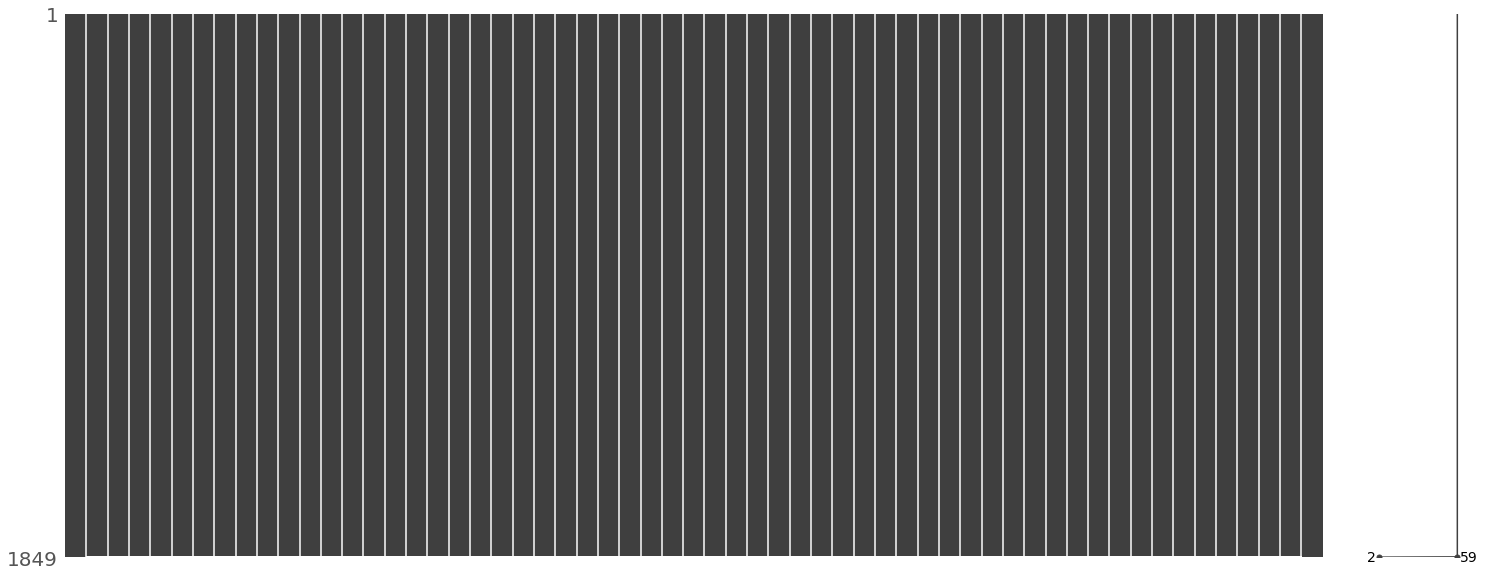

In [17]:
ax_null = msno.matrix(Dataset_df)
plt.show()

In [18]:
Dataset_df2 = Dataset_df.copy()

Se eliminan renglones con datos nulos

In [19]:
Dataset_df2.dropna(how = 'any', axis = 0, inplace = True)

In [22]:
Dataset_df2.drop(columns='Unnamed: 0', inplace = True)

Estadísticos Descriptivos

In [23]:
Dataset_df2.describe()

,Layer_1,Layer_2,Layer_3,Layer_4,Layer_5,Layer_6,Layer_7,Layer_8,Layer_9,Layer_10,...,Layer_48,Layer_49,Layer_50,Layer_51,Layer_52,Layer_53,Layer_54,Layer_55,Layer_56,Layer_57
count,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,...,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000,1847.000000
mean,8975.262588,10031.440173,10109.574445,16636.940444,15012.697347,11847.310774,2816.877098,1073.929616,387.832702,-0.035734,...,-133.152680,-11.131565,-76.943692,-23.001083,2515.342718,1478.937195,3772.653492,933.903086,16.838657,178.286410
std,734.339280,1031.606717,1460.616154,1463.609329,2480.033192,2080.393575,307.996457,142.233295,214.233919,32.615472,...,45.685313,7.370736,22.801562,6.595576,864.022891,481.422023,1295.783693,274.066405,12.151935,102.651815
min,7769.000000,8353.000000,7946.000000,11506.000000,7842.000000,7466.000000,2154.000000,436.000000,-157.000000,-258.000000,...,-321.000000,-49.000000,-156.000000,-57.000000,367.000000,219.000000,551.000000,337.000000,0.000000,-1.000000
25%,8463.500000,9332.000000,8947.500000,15669.500000,13308.000000,10280.000000,2609.000000,992.000000,221.000000,-10.000000,...,-163.000000,-15.000000,-91.000000,-26.000000,1932.000000,1200.000000,2898.000000,775.000000,6.000000,89.500000
50%,8772.000000,9753.000000,9692.000000,16521.000000,14424.000000,11345.000000,2734.000000,1073.000000,359.000000,7.000000,...,-129.000000,-10.000000,-73.000000,-22.000000,2378.000000,1368.000000,3567.000000,919.000000,16.000000,184.000000
75%,9337.500000,10608.500000,10918.500000,17525.500000,16301.500000,12958.500000,2960.000000,1157.000000,522.000000,19.000000,...,-100.500000,-6.000000,-59.500000,-19.000000,2871.000000,1616.000000,4306.000000,1099.500000,26.000000,257.500000
max,13428.000000,15799.000000,17110.000000,22729.000000,23596.000000,19815.000000,4112.000000,1623.000000,1129.000000,98.000000,...,17.000000,4.000000,-21.000000,-8.000000,6813.000000,5176.000000,10218.000000,1792.000000,65.000000,359.000000


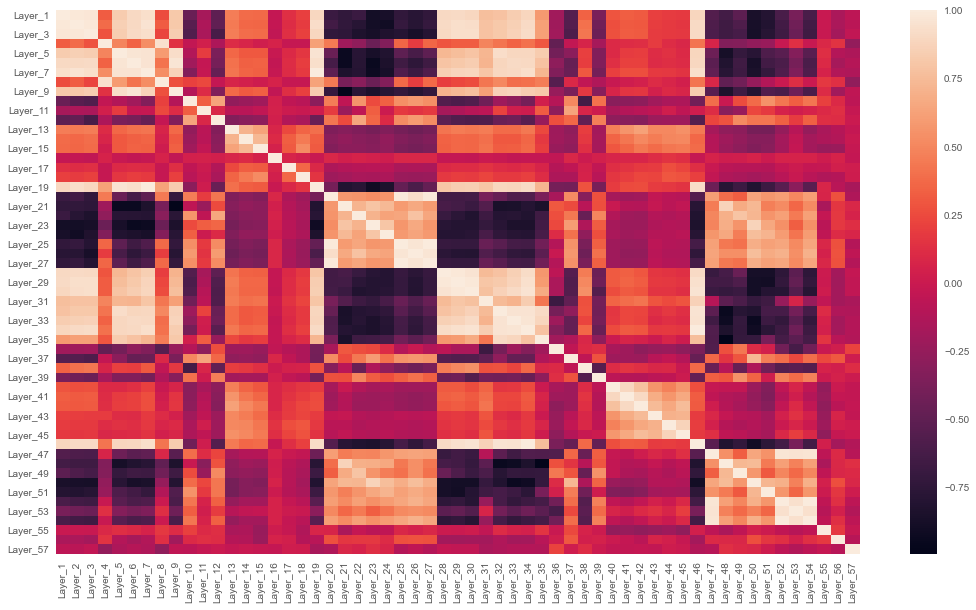

In [421]:
data_corr = Dataset_df2.corr(method = 'pearson')
ax_corr = sns.heatmap(data_corr, annot=  False)
plt.show()

Gráfico de barras - Cantidad de instancias por Clase

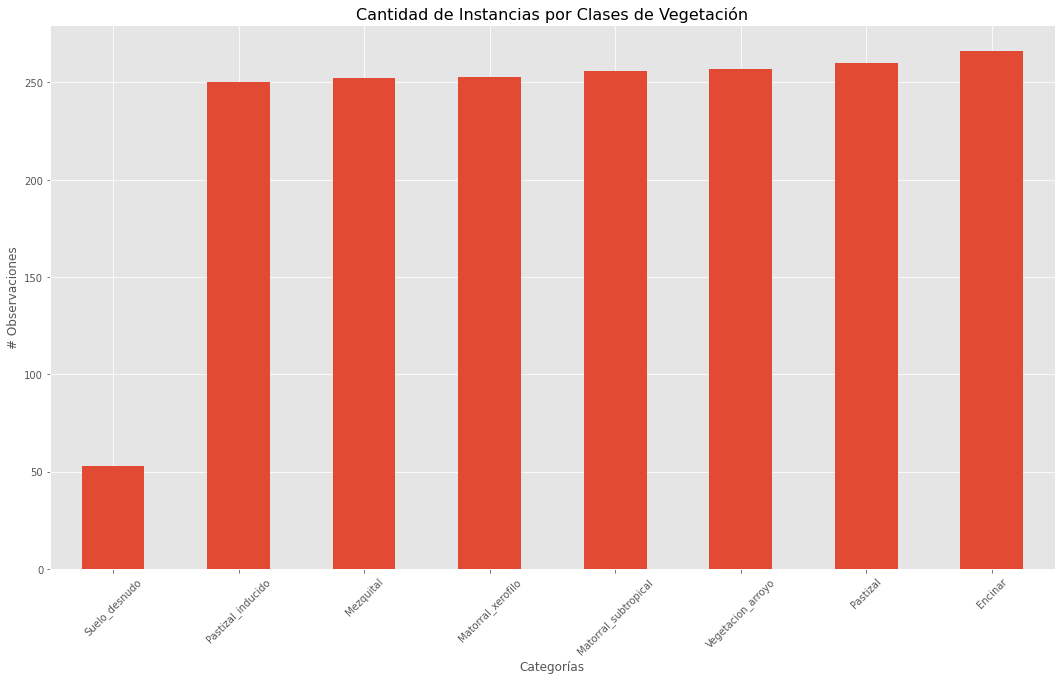

In [34]:
fig_clas, ax_class = plt.subplots(nrows = 1, ncols = 1)
ax_class.set_title('Cantidad de Instancias por Clases de Vegetación', fontsize = 16)
Clases_count = Dataset_df2.types.value_counts(ascending=True)
Clases_count.plot(kind = 'bar',
                  xlabel = 'Categorías',
                  ylabel = '# Observaciones',
                  ax = ax_class)
ax_class.set_xticklabels(Clases_count.index.values.tolist(), rotation = 45)
plt.show()

Clases

In [36]:
print(f'Clases a Predecir: {Clases_count.index.values.tolist()}')

Clases a Predecir: ['Suelo_desnudo', 'Pastizal_inducido', 'Mezquital', 'Matorral_xerofilo', 'Matorral_subtropical', 'Vegetacion_arroyo', 'Pastizal', 'Encinar']


Boxplots de los predictores por Clase

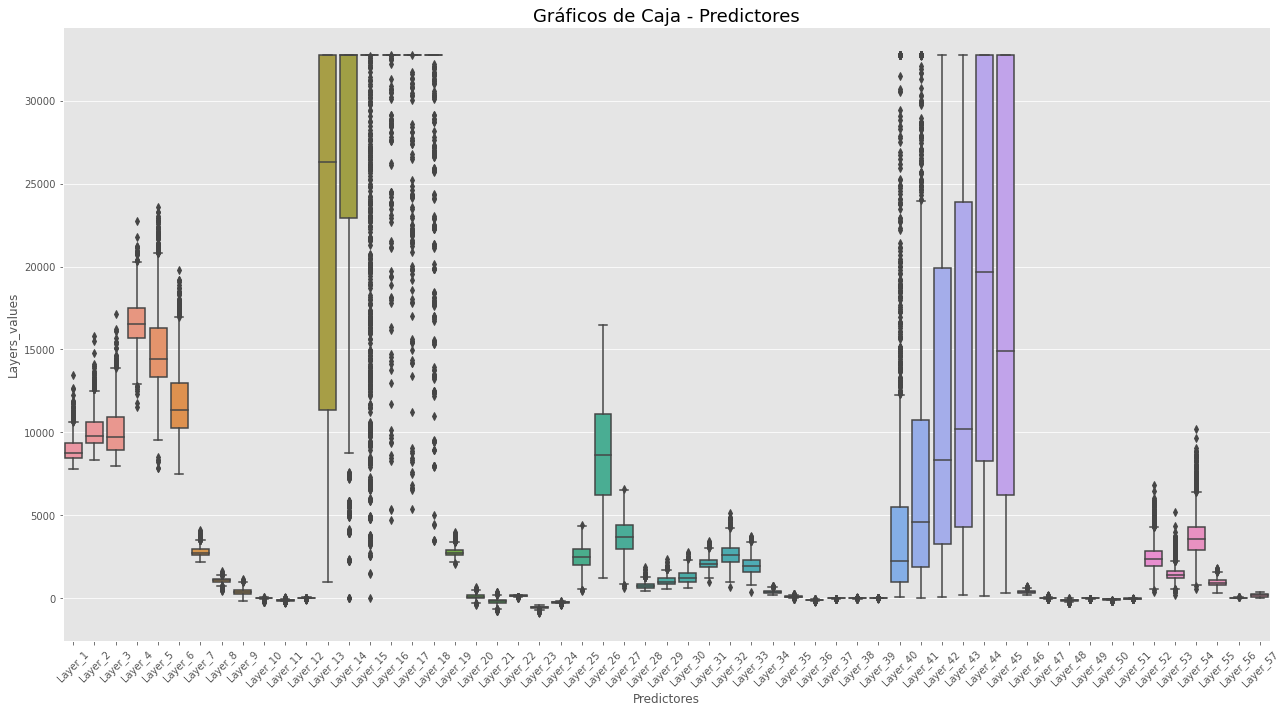

In [53]:
ax_boxplot = sns.boxplot(data = Dataset_df2.drop(columns = 'types'))
ax_boxplot.set_xticklabels(Dataset_df2.drop(columns = 'types').columns, rotation = 45)
ax_boxplot.set_title('Gráficos de Caja - Predictores', fontsize = 18)
ax_boxplot.set_ylabel('Layers_values')
ax_boxplot.set_xlabel('Predictores')
plt.tight_layout()
plt.show()

## Modelo ML

**Se Realizará el entrenamiento de los siguientes Modelos de Aprendizaje Automático:**
1. RandomForest.
2. KNN
3. Máquinas de Vector Soporte (SVM).

X - Predictores

In [54]:
X = Dataset_df2.drop(columns = 'types').values

Y - Categorías
* Preprocesamiento: Label Encoder

In [56]:
CAT = Dataset_df2.types.values

Se define la instancia Label Encoder

In [61]:
le = LabelEncoder()
le.fit_transform(CAT)

array([0, 0, 0, ..., 6, 6, 6])

In [67]:
y = le.transform(CAT)

In [66]:
print(f'Clases:{le.classes_}')
print(f'Clases transforms:{le.transform(CAT)}')

Clases:['Encinar' 'Matorral_subtropical' 'Matorral_xerofilo' 'Mezquital'
 'Pastizal' 'Pastizal_inducido' 'Suelo_desnudo' 'Vegetacion_arroyo']
Clases transforms:[0 0 0 ... 6 6 6]


**Split Train - Test: (0.8 - 0.2)**

In [352]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.20)

### Modelo de Aprendizaje: Support Vector Machine

In [353]:
# Instancias de GridSearchCV object
parameters = {'C':[0.1,1,10], 'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
searcher_svm = GridSearchCV(SVC(kernel='rbf'), parameters, cv = 10)

In [354]:
# Instancias pipeline
steps_svm = [('scaler',StandardScaler()),
              ('gridsearch',searcher_svm)]

pipeline = Pipeline(steps_svm)

### Aplicando Reducción de dimensionalidad

In [408]:
# Metodos: preprocesamiento e instancia modelo SVM
steps_svm = [('scaler', StandardScaler()),
             ('pca', PCA()),
            ('SVM', SVC(kernel='rbf'))]
pipeline_svm = Pipeline(steps_svm)

# Specify the hyperparameter space
parameters_svm = {'SVM__C':[0.1,1,10], 'SVM__gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1], 'pca__n_components':[10,20,57]}
# Instantiate the GridSearchCV object: cv
cv_svm = GridSearchCV(pipeline_svm, parameters_svm, cv = 5)

In [409]:
cv_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()), ('SVM', SVC())]),
             param_grid={'SVM__C': [0.1, 1, 10],
                         'SVM__gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                         'pca__n_components': [10, 20, 57]})

In [410]:
print('Best CV params', cv_svm.best_params_)
print('Best CV accuray', cv_svm.best_score_)

Best CV params {'SVM__C': 10, 'SVM__gamma': 0.01, 'pca__n_components': 20}
Best CV accuray 0.7576225377920294


In [411]:
y_predsvm = cv_svm.predict(X_test)
print('Accuracy: {}'.format(cv_svm.score(X_test, y_test)))

Accuracy: 0.8054054054054054


PCA al Conjunto de Datos - Predictores

In [413]:
pca_ = PCA(n_components=57)
pca__transf = pca_.fit_transform(X)

In [415]:
X.shape

(1847, 57)

In [427]:
pca_.explained_variance_ratio_[:5].sum()

0.8962934040888495

In [424]:
var_cum = pd.DataFrame(pca_.explained_variance_ratio_.cumsum(), columns=['Varianza_acumulada'])
var_cum.head()

,Varianza_acumulada
0,0.621420
1,0.740954
2,0.820742
3,0.862267
4,0.896293


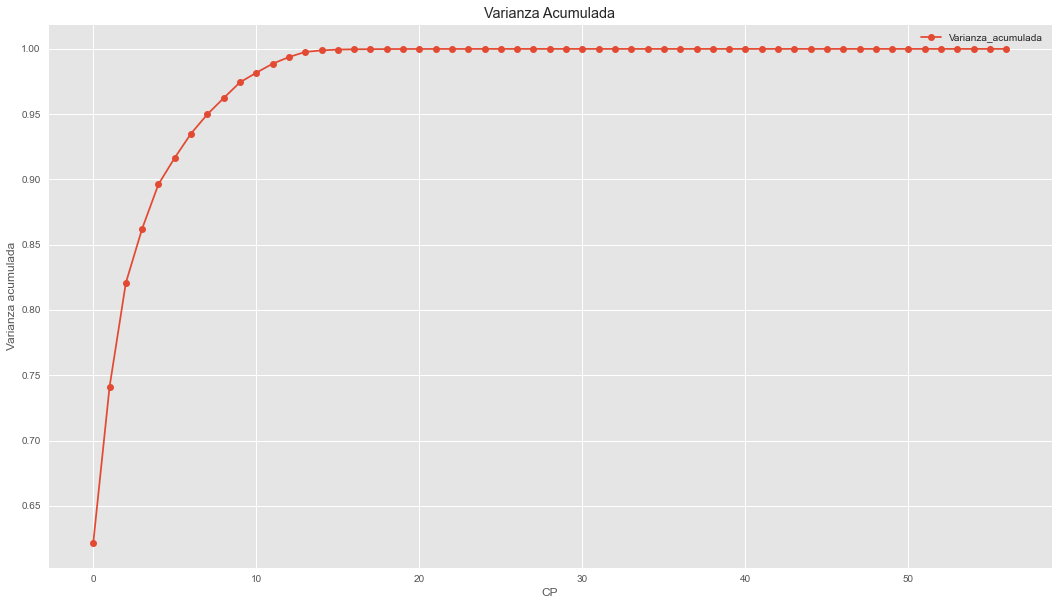

In [426]:
ax_varcum = var_cum.plot(kind = 'line',
                         marker = 'o', 
                         xlabel = 'CP',
                         ylabel = 'Varianza acumulada',
                         title = 'Varianza Acumulada')
plt.show()

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[6.21420185e-01 1.19533518e-01 7.97878100e-02 4.15259549e-02
 3.40259365e-02 2.03099597e-02 1.85895968e-02 1.47297725e-02
 1.23919860e-02 1.20924126e-02 7.32437823e-03 6.91590272e-03
 5.09243068e-03 3.94100606e-03 1.16352271e-03 6.43752257e-04
 2.20259737e-04 9.67079538e-05 7.04158358e-05 6.03887368e-05
 1.84007693e-05 1.44172337e-05 1.04129069e-05 9.04022361e-06
 4.13778029e-06 2.86236844e-06 2.06816209e-06 1.95429622e-06
 6.51346372e-07 1.07824060e-07 4.78344234e-08 1.82403505e-10
 1.56438706e-10 1.48702278e-10 1.38134853e-10 1.34880659e-10
 1.29769623e-10 1.13465306e-10 1.04557630e-10 9.98312442e-11
 9.63334233e-11 9.38797985e-11 9.13378997e-11 8.90543331e-11
 8.73876663e-11 8.55352303e-11 8.29153760e-11 8.24046634e-11
 7.91348544e-11 7.86639836e-11 7.65562861e-11 7.60742068e-11
 7.48504764e-11 7.36406952e-11 7.26403218e-11 7.

Text(0.5, 0, 'Componente principal')

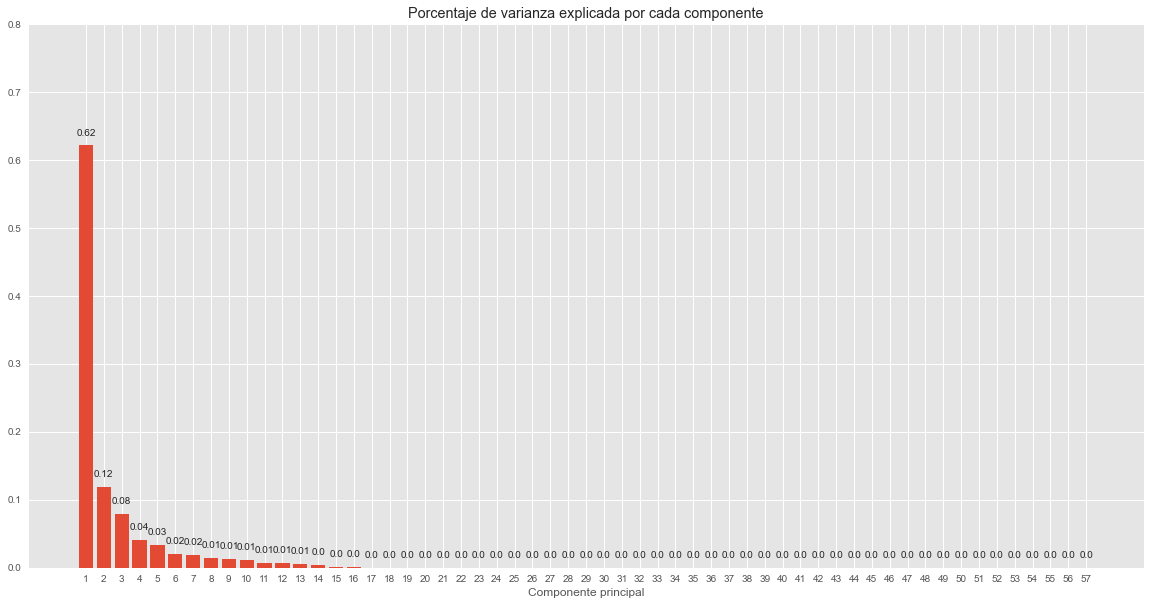

In [417]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(pca_.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
ax.bar(
    x      = np.arange(pca_.n_components_) + 1,
    height = pca_.explained_variance_ratio_
)

for x, y in zip(np.arange(len(X_train)) + 1, pca_.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca_.n_components_) + 1)
ax.set_ylim(0, 0.8)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')

### Ajuste Modelo SVM 
* se cambia la secuencia

In [293]:
# Metodos: preprocesamiento e instancia modelo SVM
steps_svm = [('scaler', StandardScaler()),
            ('SVM', SVC(kernel='rbf'))]
pipeline_svm = Pipeline(steps_svm)

# Specify the hyperparameter space
parameters_svm = {'SVM__C':[0.1,1,10], 'SVM__gamma':[0.00001, 0.0001, 0.001, 0.01, 0.1]}
# Instantiate the GridSearchCV object: cv
cv_svm = GridSearchCV(pipeline_svm, parameters_svm, cv = 5)

se ajusta el modelo a los datos de entrenamiento

In [294]:
cv_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVM', SVC())]),
             param_grid={'SVM__C': [0.1, 1, 10],
                         'SVM__gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1]})

In [295]:
print('Best CV params', cv_svm.best_params_)
print('Best CV accuray', cv_svm.best_score_)

Best CV params {'SVM__C': 10, 'SVM__gamma': 0.01}
Best CV accuray 0.763039395327531


In [296]:
y_predsvm = cv_svm.predict(X_test)

In [298]:
print('Accuracy: {}'.format(cv_svm.score(X_test, y_test)))

Accuracy: 0.8162162162162162


### Ajustar Modelo: método .fit()

In [355]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gridsearch',
                 GridSearchCV(cv=10, estimator=SVC(),
                              param_grid={'C': [0.1, 1, 10],
                                          'gamma': [1e-05, 0.0001, 0.001, 0.01,
                                                    0.1]}))])

Reporte de los mejores parametros y su puntuación

In [356]:
print('Best CV params', searcher_svm.best_params_)
print('Best CV accuray', searcher_svm.best_score_)

Best CV params {'C': 10, 'gamma': 0.01}
Best CV accuray 0.7684500827357971


Accuracy Conjunto de prueba

In [357]:
y_pred = pipeline.predict(X_test)

Classification Report

Train

In [358]:
print(f'Clasffication Report Train: {classification_report(y_train, pipeline.predict(X_train))}')

Clasffication Report Train:               precision    recall  f1-score   support

           0       0.92      0.95      0.93       216
           1       0.87      0.94      0.91       198
           2       0.91      0.86      0.88       201
           3       0.93      0.84      0.88       204
           4       0.97      0.89      0.93       210
           5       0.81      0.91      0.86       195
           6       1.00      1.00      1.00        44
           7       0.98      0.97      0.97       209

    accuracy                           0.91      1477
   macro avg       0.92      0.92      0.92      1477
weighted avg       0.92      0.91      0.91      1477



Test

In [359]:
print(f'Clasffication Report Test: {classification_report(y_test, y_pred)}')

Clasffication Report Test:               precision    recall  f1-score   support

           0       0.73      0.88      0.80        50
           1       0.86      0.93      0.89        58
           2       0.84      0.71      0.77        52
           3       0.76      0.67      0.71        48
           4       0.88      0.84      0.86        50
           5       0.73      0.80      0.77        55
           6       1.00      0.78      0.88         9
           7       0.91      0.88      0.89        48

    accuracy                           0.82       370
   macro avg       0.84      0.81      0.82       370
weighted avg       0.82      0.82      0.82       370



In [335]:
CAT_LE = pd.DataFrame(data = {
    'types':Dataset_df2.types.values,
    'CAT_LE':y
    })

CAT_types = CAT_LE.drop_duplicates('types').sort_values(by= 'CAT_LE').reset_index(drop = True)
CAT_types

,types,CAT_LE
0,Encinar,0
1,Matorral_subtropical,1
2,Matorral_xerofilo,2
3,Mezquital,3
4,Pastizal,4
5,Pastizal_inducido,5
6,Suelo_desnudo,6
7,Vegetacion_arroyo,7


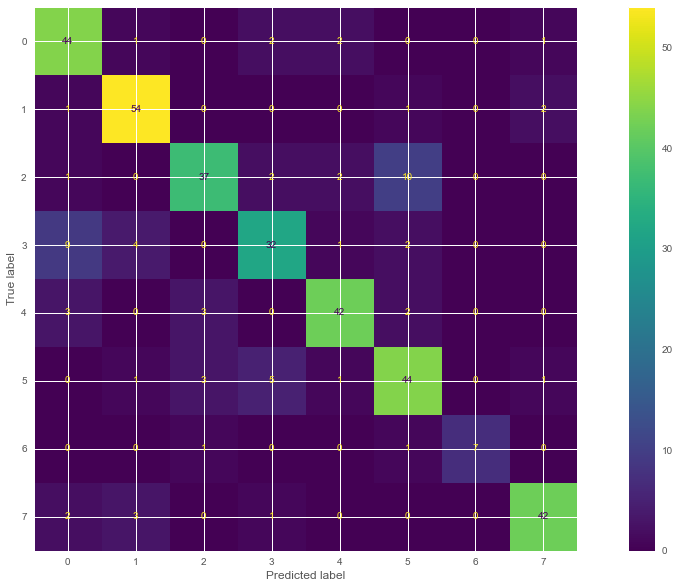

In [360]:
plot_confusion_matrix(pipeline,X_test,y_test, 
                      include_values = True, 
                      cmap = 'viridis',)
plt.show()

In [361]:
print(f'Precisión Cojunto Test con los mejores Hyperparameters (SVM): {pipeline.score(X_test,y_test)}')

Precisión Cojunto Test con los mejores Hyperparameters (SVM): 0.8162162162162162


Todo el set de datos

In [362]:
print(f'Precisión Cojunto de datos con los mejores Hyperparameters (SVM): {pipeline.score(X,y)}')

Precisión Cojunto de datos con los mejores Hyperparameters (SVM): 0.8933405522468868


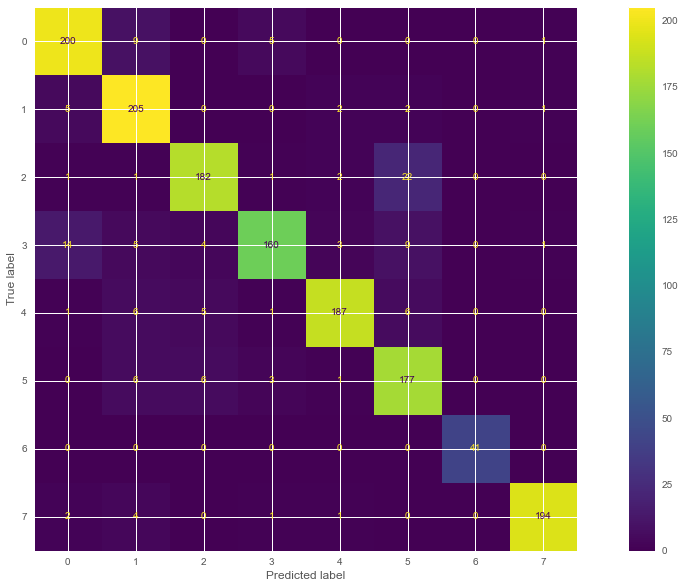

In [351]:
plot_confusion_matrix(pipeline,X_train,y_train, 
                      include_values = True, 
                      cmap = 'viridis',)
plt.show()

### Modelo de Aprendizaje: Random Forest

In [365]:
# Instancias de GridSearchCV object
parameters_RF = {'max_depth':[10,20,40],#[20,40,60,80,100],
                 'max_features':['auto', 'sqrt'],
                 'min_samples_leaf': [2,4,10],#[1,2,4,10],
                 'min_samples_split':[2,5,10],#[2,5,10,20],
                 'n_estimators':[20,50,100,200]}#[600,800,1000,1200,1800,2000]}
searcher_RF = GridSearchCV(RandomForestClassifier(), parameters_RF, cv = 10)

In [366]:
# Instancias pipeline
steps_RF = [('gridsearch',searcher_RF)]

pipeline_RF = Pipeline(steps_RF)

Ajustar Modelo: método .fit()

In [368]:
searcher_RF.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 40],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 4, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 50, 100, 200]})

Reporte de los mejores parametros y su puntuación

In [369]:
print('Best CV params', searcher_RF.best_params_)
print('Best CV accuray', searcher_RF.best_score_)

Best CV params {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best CV accuray 0.7867576760433904


Accuracy Conjunto de prueba

In [370]:
y_predRF = searcher_RF.predict(X_test)

Classification Report

Test

In [371]:
print(f'Clasffication Report Test RF: {classification_report(y_test,y_predRF)}')

Clasffication Report Test RF:               precision    recall  f1-score   support

           0       0.75      0.84      0.79        50
           1       0.75      0.83      0.79        58
           2       0.78      0.69      0.73        52
           3       0.69      0.73      0.71        48
           4       0.84      0.76      0.80        50
           5       0.70      0.78      0.74        55
           6       1.00      0.78      0.88         9
           7       1.00      0.83      0.91        48

    accuracy                           0.78       370
   macro avg       0.81      0.78      0.79       370
weighted avg       0.79      0.78      0.78       370



In [372]:
print(f'Precisión Cojunto Test con los mejores Hyperparameters (RF): {searcher_RF.score(X_test,y_test)}')

Precisión Cojunto Test con los mejores Hyperparameters (RF): 0.7810810810810811


### Modelo de Aprendizaje: KNN

In [278]:
# Instancias pipeline
steps_knn = [('scaler',StandardScaler()),
              ('knn',KNeighborsClassifier())]

pipeline_knn = Pipeline(steps_knn)

In [284]:
# Instancias de GridSearchCV object
parameters_knn = {'knn__n_neighbors': np.arange(1,50)}
cv_knn = GridSearchCV(pipeline_knn, parameters_knn, cv = 10)
cv_knn.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

Reporte de los mejores parametros y su puntuación

In [285]:
print('Best CV params', cv_knn.best_params_)
print('Best CV accuray', cv_knn.best_score_)

Best CV params {'knn__n_neighbors': 8}
Best CV accuray 0.6926457069314214


Train

In [286]:
cv_knn.score(X_train, y_train)

0.7623561272850372

Test

In [287]:
cv_knn.score(X_test, y_test)

0.7297297297297297